# Project for Wikishop with BERT

The Wikishop online store is launching a new service. Now users can
edit and add product descriptions, like in wiki communities. That is, clients
propose their own edits and comment on the changes of others. The store needs
a tool that will look for toxic comments and send them to
moderation.

P.s initially the project was executed in Russian, and only then it was translated into English using an auto-translator, so errors or untranslated sections are possible.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tqdm


from sklearn.model_selection import train_test_split, GridSearchCV,StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier, Pool


from transformers import BertModel, BertTokenizer, AdamW, BertForMaskedLM


import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, random_split, Subset, TensorDataset



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocessing

In [ ]:
data = pd.read_csv('/datasets/toxic_comments.csv').set_index('Unnamed: 0', drop=True).reset_index(drop=True)

In [ ]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [ ]:
data.duplicated().sum()

0

In [ ]:
data.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


We see an imbalance across classes, so it will be important to stratify the test and training samples

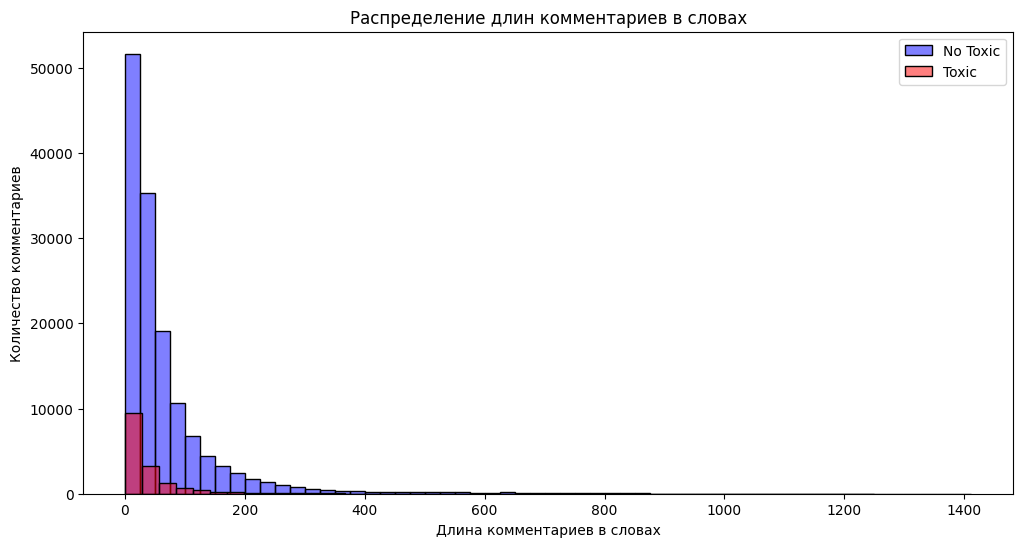

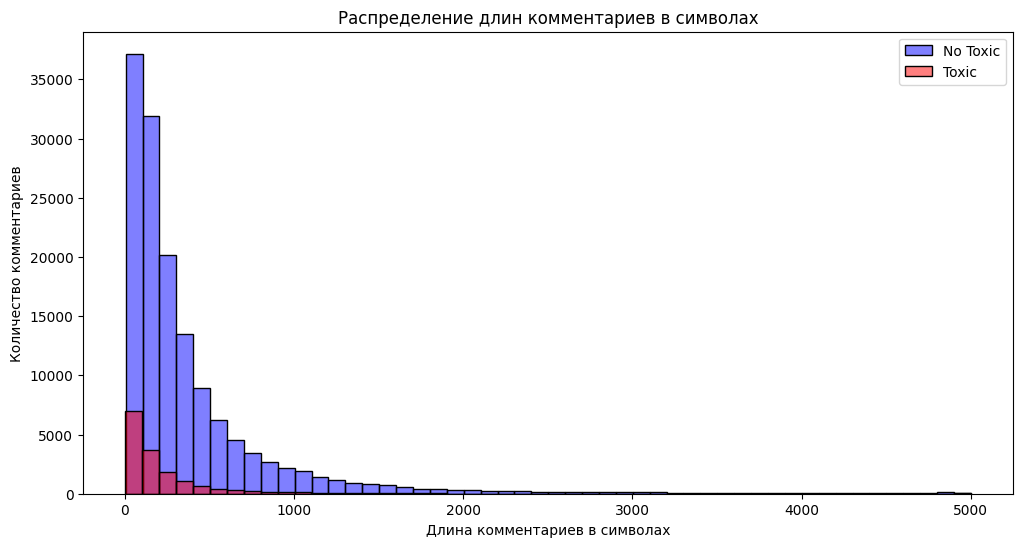

In [ ]:
data['text_length_words'] = data['text'].apply(lambda x: len(x.split()))
data['text_length_chars'] = data['text'].apply(len)

plt.figure(figsize=(12, 6))

sns.histplot(data[data['toxic'] == 0], x='text_length_words', bins=50, alpha=0.5, color='blue', label='No Toxic')

sns.histplot(data[data['toxic'] == 1], x='text_length_words', bins=50, alpha=0.5, color='red', label='Toxic')

plt.xlabel('Длина комментариев в словах')
plt.ylabel('Количество комментариев')
plt.title('Распределение длин комментариев в словах')
plt.legend()

plt.show()

plt.figure(figsize=(12, 6))

sns.histplot(data[data['toxic'] == 0], x='text_length_chars', bins=50, alpha=0.5, color='blue', label='No Toxic')

sns.histplot(data[data['toxic'] == 1], x='text_length_chars', bins=50, alpha=0.5, color='red', label='Toxic')

plt.xlabel('Длина комментариев в символах')
plt.ylabel('Количество комментариев')
plt.title('Распределение длин комментариев в символах')
plt.legend()

plt.show()
data = data.drop(['text_length_words', 'text_length_chars'],axis=1)

## Text encoding

Before obtaining embeddings using BERT, we need to additionally train BERT on our dataset to improve coding accuracy.

In [ ]:
sentences = data.text.values

### Training BERT

BERT was originally introduced as a model for pre-training on a masked language modeling task. This means that during pre-training, BERT tried to “guess” the masked words in a sentence based on context.

When we talk about "retraining BERT just to get embeddings, i.e. without any classification head on top", it means that we just want BERT to learn to better understand and represent our particular dataset, without trying to classify or decide which - another specific task using these embeddings.

Simply put, instead of teaching BERT to perform a specific task on our dataset (such as classification), we want to “tune” BERT so that it better understands the features of our dataset. We do this by continuing training on the MLM problem, minimizing the reconstruction error for masked tokens. Thus, the embeddings that we receive from BERT after such additional training will be more relevant and accurate for our dataset.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 512

texts = data.text.values.tolist()
labels = data.toxic.values
# Токенизация данных и создание "маскированных" входов
inputs = tokenizer(texts, return_tensors="pt", max_length=MAX_LEN, truncation=True, padding=True)
inputs["labels"] = inputs.input_ids.detach().clone()

# создаем маски для 15% токенов для маскированного языкового моделирования
rand = torch.rand(inputs.input_ids.shape)
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102) * (inputs.input_ids != 0)

for i in range(inputs.input_ids.shape[0]):
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    inputs.input_ids[i, selection] = 103  # 103 is the token ID for '[MASK]'

dataset = TensorDataset(inputs.input_ids, inputs.attention_mask, inputs.labels)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=25)
val_dataloader = DataLoader(val_dataset, batch_size=8)


In [ ]:
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from tqdm.notebook import tqdm
EPOCHS = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(EPOCHS):
    print(f"Epoch: {epoch + 1}/{EPOCHS}")

    # Тренировка
    model.train()
    train_progress_bar = tqdm(train_dataloader, desc="Training", leave=False)
    for batch in train_progress_bar:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_progress_bar.set_postfix({'Training Loss': f'{loss.item():.4f}'})

        loss.backward()
        optimizer.step()
    train_progress_bar.close()

    # Валидация
    model.eval()
    val_loss = 0
    val_progress_bar = tqdm(val_dataloader, desc="Validation", leave=False)
    with torch.no_grad():
        for batch in val_progress_bar:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
    val_progress_bar.close()

    print(f"Epoch: {epoch + 1}, Val Loss: {val_loss / val_size:.4f}")


Epoch: 1/1


Training:   0%|          | 0/5735 [00:00<?, ?it/s]

Validation:   0%|          | 0/1992 [00:00<?, ?it/s]

Epoch: 1, Val Loss: 0.0071


In [ ]:
model_path = "fine_tuned_bert"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)


('fine_tuned_bert/tokenizer_config.json',
 'fine_tuned_bert/special_tokens_map.json',
 'fine_tuned_bert/vocab.txt',
 'fine_tuned_bert/added_tokens.json')

In [ ]:
torch.cuda.empty_cache()

### Encoding

Now let’s do the coding using the retrained tokenizer and model

In [ ]:
model = BertModel.from_pretrained(model_path, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained(model_path)

Some weights of BertModel were not initialized from the model checkpoint at fine_tuned_bert and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Токенизировать все предложения и преобразовать токены в их ID слов.
input_ids = []
attention_masks = []


for sent in sentences:
    # `encode_plus` будет:
    #   (1) Токенизировать предложение.
    #   (2) Добавить токен `[CLS]` в начало.
    #   (3) Добавить токен `[SEP]` в конец.
    #   (4) Преобразовать токены в их ID.
    #   (5) Дополнить или обрезать предложение до `max_length`
    #   (6) Создать маски внимания для токенов [PAD].
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Текст для кодирования.
                        add_special_tokens = True, # Добавить '[CLS]' и '[SEP]'
                        max_length = 512,           # Дополнить & обрезать все предложения.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Создать маски внимания.
                        return_tensors = 'pt',     # Возвращать тензоры PyTorch.
                   )

    # Добавить закодированное предложение в список.
    input_ids.append(encoded_dict['input_ids'])

    # И его маску внимания (просто различает дополнение от недополнения).
    attention_masks.append(encoded_dict['attention_mask'])

# Преобразовать списки в тензоры.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Вывести предложение 0, теперь как список ID.
print('Оригинал: ', sentences[0])
print('ID токенов:', input_ids[0])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2393: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Оригинал:  Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
ID токенов: tensor([  101,  7526,  2339,  1996, 10086,  2015,  2081,  2104,  2026,  5310,
        18442, 13076, 12392,  2050,  5470,  2020, 16407,  1029,  2027,  4694,
         1005,  1056,  3158,  9305, 22556,  1010,  2074,  8503,  2006,  2070,
         3806,  2044,  1045,  5444,  2012,  2047,  2259, 14421,  6904,  2278,
         1012,  1998,  3531,  2123,  1005,  1056,  6366,  1996, 23561,  2013,
         1996,  2831,  3931,  2144,  1045,  1005,  1049,  3394,  2085,  1012,
         6486,  1012, 16327,  1012,  4229,  1012,  2676,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
          

<ipython-input-19-572fbd9ce2f3>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


In [ ]:
features = input_ids

In [ ]:
# Проверяем наличие CUDA
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

# Переносим модель на GPU
model.to(device)

batch_size = 200
embeddings = []

# Итерируемся через данные
for i in tqdm.tqdm(range((len(features) // batch_size))):
        batch = torch.LongTensor(features[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_masks[batch_size*i:batch_size*(i+1)]).to(device)

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)

        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())  # Переносим данные с GPU на CPU и конвертируем в NumPy
features = np.concatenate(embeddings)

There are 1 GPU(s) available.
Using GPU: NVIDIA A100-SXM4-40GB


100%|██████████| 796/796 [17:05<00:00,  1.29s/it]


In [ ]:
torch.cuda.empty_cache()

In [ ]:
labels = data['toxic'][:len(features)]

## Training

### Neural network

Let's create a custom ToxicDataset for structuring embeddings and labels. With StratifiedShuffleSplit, data is divided into training, validation and test subsets while maintaining class relationships. A simple multilayer perceptron network is then created for classification. After setting the training parameters, the model is trained on the training dataset and its performance is tested on the validation data, outputting an F1 score after each epoch.

In [ ]:
# Создание PyTorch Dataset для эмбеддингов
class ToxicDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

dataset = ToxicDataset(features, labels)  # Этот код определяет dataset

# Разделение данных на train, valid и test с учетом стратификации
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=1234)
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2857, random_state=1234)  # 0.2857 * 0.3 ≈ 0.2, для выделения 20% от исходных данных

train_idx, temp_idx = next(sss1.split(features, labels[:len(features)]))
valid_idx, test_idx = next(sss2.split(features[temp_idx], labels[temp_idx]))


train_dataset = Subset(dataset, train_idx)
valid_dataset = Subset(dataset, valid_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=50)
valid_loader = DataLoader(valid_dataset, batch_size=50)
test_loader = DataLoader(test_dataset, batch_size=50)

# Определение простой последовательной сети
embedding_dim = features.shape[1]
model = nn.Sequential(
    nn.Linear(embedding_dim, 256),
    nn.ReLU(),                                   # Функция активации ReLU
    nn.Dropout(p=0.3),
    nn.Linear(256, 128),                         # Еще один полносвязный слой (вход 256, выход 128)
    nn.ReLU(),                                   # Функция активации ReLU
    nn.Linear(128, 2),                           # Выходной слой с двумя нейронами (для бинарной классификации)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Обучение сети
epochs = 10
for epoch in range(epochs):
    model.train()
    for embeddings, labels in train_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(embeddings.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Валидация
    model.eval()
    preds = []
    true = []
    for embeddings, labels in valid_loader:
        embeddings = embeddings.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(embeddings.float())
            _, pred = torch.max(outputs, dim=1)
            preds.extend(pred.cpu().numpy())
            true.extend(labels.cpu().numpy())

    print(f'Epoch: {epoch + 1}, F1 Score: {f1_score(true, preds)}')


Epoch: 1, F1 Score: 0.7257609036711641
Epoch: 2, F1 Score: 0.7414590481873788
Epoch: 3, F1 Score: 0.7349030914624379
Epoch: 4, F1 Score: 0.7464723212901224
Epoch: 5, F1 Score: 0.7534226409539231
Epoch: 6, F1 Score: 0.7389067524115754
Epoch: 7, F1 Score: 0.6861391396707383
Epoch: 8, F1 Score: 0.7439535633666559
Epoch: 9, F1 Score: 0.750822239624119
Epoch: 10, F1 Score: 0.7412359367356922


In [ ]:
torch.cuda.empty_cache()

### Classic ML models

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(features, data['toxic'].loc[:len(dataset)-1], stratify=data['toxic'].loc[:len(dataset)-1], random_state=1234, test_size=0.2)

#### CatBoost

In [ ]:
train_pool = Pool(features_train, target_train)

# 2. Перебор гиперпараметров
grid = {
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3, 5]
}

catboost_clf = CatBoostClassifier(iterations=1000, verbose=500, custom_loss=['F1'])

# Поиск по сетке с кросс-валидацией
result = catboost_clf.grid_search(grid,
                                  X=train_pool,
                                  cv=2,   # Количество фолдов для кросс-валидации
                                  verbose=True,
                                  plot=False,
                                  refit=False,  # refit=True гарантирует, что лучшая модель будет обучена на всем наборе данных
                                  search_by_train_test_ratio=True,
                                  partition_random_seed=42)

best_score = result['cv_results']['test-F1-mean'][result['params']['iterations']]
print("Best parameters found: ", result['params'])
print("Best Score (F1):", best_score)


0:	learn: 0.6547908	test: 0.6549649	best: 0.6549649 (0)	total: 109ms	remaining: 1m 48s
500:	learn: 0.1352889	test: 0.1437576	best: 0.1437576 (500)	total: 26.7s	remaining: 26.6s
999:	learn: 0.1205966	test: 0.1372606	best: 0.1372606 (999)	total: 51.7s	remaining: 0us

bestTest = 0.137260578
bestIteration = 999

0:	loss: 0.1372606	best: 0.1372606 (0)	total: 53.6s	remaining: 9m 49s
0:	learn: 0.5739157	test: 0.5743333	best: 0.5743333 (0)	total: 52.1ms	remaining: 52s
500:	learn: 0.1082862	test: 0.1341436	best: 0.1341436 (500)	total: 25.8s	remaining: 25.7s
999:	learn: 0.0857593	test: 0.1308572	best: 0.1308572 (999)	total: 48.8s	remaining: 0us

bestTest = 0.1308572194
bestIteration = 999

1:	loss: 0.1308572	best: 0.1308572 (1)	total: 1m 42s	remaining: 8m 32s
0:	learn: 0.6547907	test: 0.6549650	best: 0.6549650 (0)	total: 55.8ms	remaining: 55.8s
500:	learn: 0.1354420	test: 0.1438275	best: 0.1438275 (500)	total: 27.1s	remaining: 27s
999:	learn: 0.1207988	test: 0.1372616	best: 0.1372616 (999)	total

#### Logistic Regression

In [ ]:
# Определение параметров для перебора
param_grid = {
      'C': [0.1, 1, 100], # Обратный коэффициент регуляризации
      'penalty': ['l1', 'l2'], # Тип регуляризации
      'solver': ['liblinear'] # Solver, который поддерживает L1 и L2 регуляризацию
}

# Инициализация GridSearchCV
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, scoring='f1', cv=2, verbose=3, n_jobs=-1)

# Обучение модели на обучающем наборе
grid_search.fit(features_train, target_train)

# Получение лучших параметров и лучшего оценщика
best_params = grid_search.best_params_
best_f1 = grid_search.best_score_
best_estimator = grid_search.best_estimator

print(f"Logistic Regression Best Parameters: {best_params}")
print(f"Logistic Regression F1 Score (from GridSearchCV): {best_f1}")



Fitting 2 folds for each of 6 candidates, totalling 12 fits
[CV 1/2] END C=0.1, penalty=l1, solver=liblinear;, score=0.736 total time=  48.1s
[CV 2/2] END C=0.1, penalty=l1, solver=liblinear;, score=0.726 total time=  46.9s
[CV 1/2] END C=0.1, penalty=l2, solver=liblinear;, score=0.753 total time=  20.7s
[CV 2/2] END C=0.1, penalty=l2, solver=liblinear;, score=0.741 total time=  20.0s
[CV 1/2] END .C=1, penalty=l1, solver=liblinear;, score=0.762 total time= 3.6min
[CV 2/2] END .C=1, penalty=l1, solver=liblinear;, score=0.750 total time= 3.5min
[CV 1/2] END .C=1, penalty=l2, solver=liblinear;, score=0.763 total time=  33.7s
[CV 2/2] END .C=1, penalty=l2, solver=liblinear;, score=0.751 total time=  32.9s
[CV 1/2] END C=100, penalty=l1, solver=liblinear;, score=0.761 total time= 5.9min
[CV 2/2] END C=100, penalty=l1, solver=liblinear;, score=0.750 total time= 6.1min
[CV 1/2] END C=100, penalty=l2, solver=liblinear;, score=0.761 total time=  35.8s
[CV 2/2] END C=100, penalty=l2, solver=lib

## Test scoring

### Neural network

In [ ]:
# Предсказание на тестовой выборке
model.eval()
preds_test = []
true_test = []
for embeddings, labels in test_loader:
    embeddings = embeddings.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(embeddings.float())
        _, pred = torch.max(outputs, dim=1)
        preds_test.extend(pred.cpu().numpy())
        true_test.extend(labels.cpu().numpy())

print(f'Test F1 Score: {f1_score(true_test, preds_test)}')

Test F1 Score: 0.7703150912106136


### CatBoost

In [ ]:
model_cb = CatBoostClassifier(iterations=1000, verbose=500, **result['params'])
model_cb.fit(features_train, target_train)
preds_cb = model_cb.predict(features_test)
print(f'Test F1 Score: {f1_score(target_test, preds_cb)}')

0:	learn: 0.5638616	total: 109ms	remaining: 1m 48s
500:	learn: 0.0896292	total: 47.6s	remaining: 47.4s
999:	learn: 0.0611729	total: 1m 36s	remaining: 0us
Test F1 Score: 0.7392955801104972


### Logistic Regression

In [ ]:
model_lr = LogisticRegression(max_iter=1000, **best_params)
model_lr.fit(features_train, target_train)
preds_lr = model_lr.predict(features_test)
print(f'Test F1 Score: {f1_score(target_test, preds_lr)}')

Test F1 Score: 0.7648648648648648


## Conclusion

As part of this project, a model was developed for the Wikishop online store that can identify toxic comments in product descriptions. This is especially important given the new functionality that allows users to make and comment changes to descriptions, similar to what is done in wiki communities. Thanks to the use of modern deep learning methods and data representation in the form of embeddings, we were able to create an effective model that went through the stages of training and validation. Thus, Wikishop now has a tool that automatically highlights potentially toxic comments for further moderation.